# Adam Research Linear Solvers 

In [1]:
using LinearAlgebra
using SparseArrays
using DelimitedFiles
using IterativeSolvers
using Preconditioners
using Plots 

## Section 1: Introduction 
More later. 

## Section 2: Read Data Files from Disk and Convert to Linear System   

### Read RHS vector of size 30k (was 7080 (was 7103 before)) 
Skip over first line to skip size information.

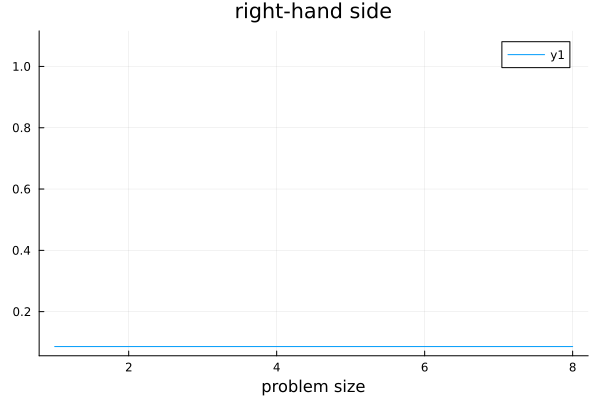

In [2]:
file = open("B.dat", "r")
b = readdlm(file, Float64, skipstart=1);
plot(b,xlabel="problem size", title="right-hand side")
#size(b)

In [8]:
b

8×1 Matrix{Float64}:
 0.08599937418303602
 0.08599937418303602
 0.08599937418303602
 0.08599937418303602
 0.08599937418303602
 0.08599937418303602
 0.08599937418303602
 0.08599937418303602

### Read sparse coefficient matrix of size 7080-by-7080 and 44246 (was 7103-by-7103 and 44355) non-zero elements from file 
1. ia is one element longer than problem size. This is because ia[end] - ia[end-1] holds the number of non-zeros of the last row of the coefficient matrix. Read by skipping over one line of row information;
1. ja is an integer vector of size 44355. ja contains the column index of the non-zero entries; 
1. a is a float vector of size 44355. a contains matrix entries. 

In [5]:
n = 8
file = open("ia.dat", "r")
ia = readdlm(file, Int64, skipstart=1); 
ia = reduce(vcat,ia)
file = open("ja.dat", "r")
ja = readdlm(file, Int64, skipstart=1); 
ja = reduce(vcat,ja)
file = open("A.dat", "r")
a = readdlm(file, Float64, skipstart=1)
a = reduce(vcat,a);

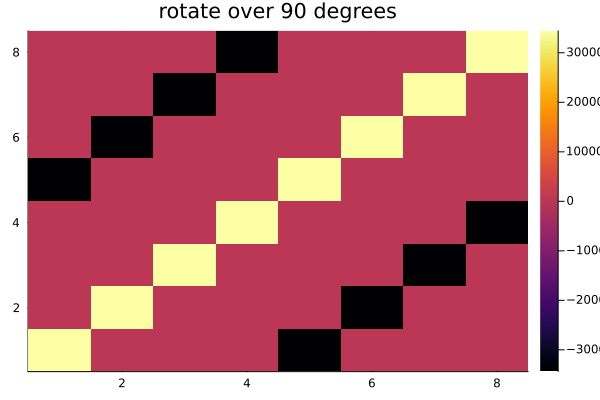

In [27]:
A = SparseMatrixCSC(n,n,ia,ja,a)
heatmap(Matrix(A), title="rotate over 90 degrees")

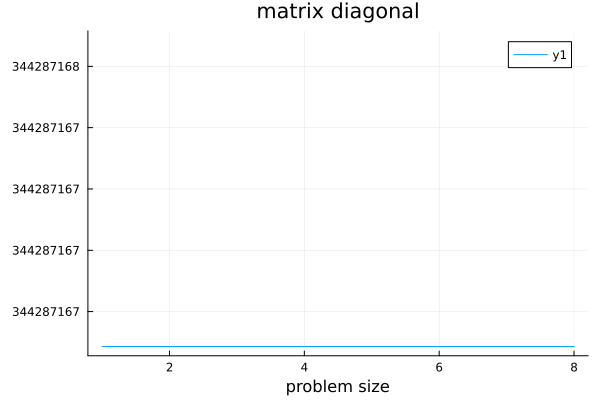

In [7]:
diagvals = [A[i,i] for i = 1:n]
plot(diagvals,xlabel="problem size", title="matrix diagonal")

### LU-factorization of the 

In [11]:
L,U = lu(Matrix(A))
display(L)
display(U)

8×8 Matrix{Float64}:
  1.0           0.0           0.0          …   0.0        0.0       0.0
 -0.000399666   1.0           0.0              0.0        0.0       0.0
 -0.000399666  -1.59733e-7    1.0              0.0        0.0       0.0
  0.0          -0.000399666  -0.000399666      0.0        0.0       0.0
 -0.999166     -0.000399333  -0.000399333      0.0        0.0       0.0
  0.0          -0.999166     -1.596e-7     …   1.0        0.0       0.0
  0.0           0.0          -0.999166        -0.298009   1.0       0.0
  0.0           0.0           0.0             -0.621748  -0.885692  1.0

8×8 Matrix{Float64}:
 3.44287e8  -137600.0        …        0.0            0.0
 0.0              3.44287e8           0.0            0.0
 0.0              0.0                -3.44e8         0.0
 0.0              0.0                -1.37485e5     -3.44e8
 0.0              0.0                -2.74971e5   -109.805
 0.0              0.0        …  -131821.0           -2.75023e5
 0.0              0.0                 4.03055e5     -3.56983e5
 0.0              0.0                 0.0        86878.6

### Explicity compute the inverse A (do evil)

In [16]:
Ainv = inv(Matrix(A))

8×8 Matrix{Float64}:
 1.15103e-5  1.01946e-5  1.01946e-5  …  1.01946e-5  1.01946e-5  9.76864e-6
 1.01946e-5  1.15103e-5  9.76864e-6     1.15089e-5  9.76864e-6  1.01946e-5
 1.01946e-5  9.76864e-6  1.15103e-5     9.76864e-6  1.15089e-5  1.01946e-5
 9.76864e-6  1.01946e-5  1.01946e-5     1.01946e-5  1.01946e-5  1.15089e-5
 1.15089e-5  1.01946e-5  1.01946e-5     1.01946e-5  1.01946e-5  9.76864e-6
 1.01946e-5  1.15089e-5  9.76864e-6  …  1.15103e-5  9.76864e-6  1.01946e-5
 1.01946e-5  9.76864e-6  1.15089e-5     9.76864e-6  1.15103e-5  1.01946e-5
 9.76864e-6  1.01946e-5  1.01946e-5     1.01946e-5  1.01946e-5  1.15103e-5

### Read Solution vector (was (for verification purposes) of size 7103) 
Again, skip over first line to skip size information.

In [13]:
# file = open("X.dat", "r")
# x = readdlm(file, Float64, skipstart=1)
# plot(x,xlabel="problem size", title="reference solution provided")

## Section 3: Solve by sparse direct method 
Do not recover the reference solution. Issue with scaling or boundary conditions. 

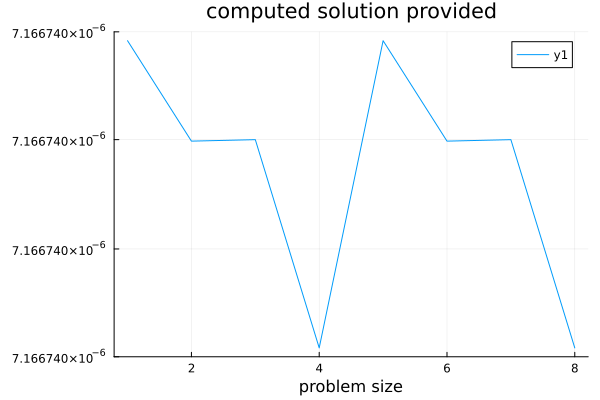

GKS: Possible loss of precision in routine SET_WINDOW


In [14]:
myx = A \ b;
plot(myx,xlabel="problem size", title="computed solution")

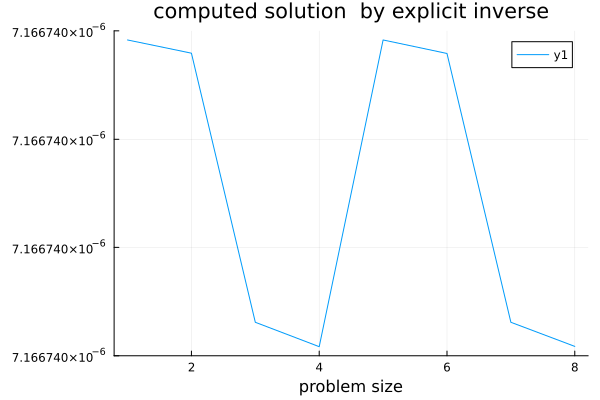

In [18]:
myx2 = Ainv * b;
plot(myx2,xlabel="problem size", title="computed solution  by explicit inverse")

## Section 4: Solve by iterative method 

In [28]:
prec  = AMGPreconditioner{RugeStuben}(A)
u, ch = cg(A, b, Pl=prec, maxiter=100000, log=true)

display(ch)

Converged after 1 iterations.